# Automathon 2024

In [1]:
!pip install pyav

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.8/17.8 MB 2.4 MB/s eta 0:00:0000:0100:01


## Imports

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torchvision.io as io
import os
import json
from tqdm import tqdm
import csv
import timm
import wandb
import time

from PIL import Image
import torchvision.transforms as transforms

/opt/anaconda3/envs/hackathon/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utilities

In [4]:
import matplotlib.pyplot as plt

def display_image(img):
    img = img.permute(1,2,0)
    plt.imshow(img)
    
def extract_frames(video_path, nb_frames=10, delta=1, timeit=False):
    # use time to measure the time it takes to resize a video
    t1 = time.time()
    reader = io.VideoReader(video_path)
    # take 10 frames uniformly sampled from the video
    frames = []
    for i in range(nb_frames):
        reader.seek(delta)
        frame = next(reader)
        frames.append(frame['data'])
    t2 = time.time()     
    video = torch.stack(frames)
    if timeit:
        print(f"read: {t2-t1}")
    return video

def smart_resize(data, size): # kudos louis
    # Prends un tensor de shape [...,C,H,W] et le resize en [...C,size,size]
    # x, y, height et width servent a faire un crop avant de resize

    full_height = data.shape[-2]
    full_width = data.shape[-1]

    if full_height > full_width:
        alt_height = size
        alt_width = int(full_width / (full_height / size))
    elif full_height < full_width:
        alt_height = int(full_height / (full_width / size))
        alt_width = size
    else:
        alt_height = size
        alt_width = size
    tr = transforms.Compose([
        transforms.Resize((alt_height, alt_width)),
        transforms.CenterCrop(size)
    ])
    return tr(data)

def resize_data(data, new_height, new_width, x=0, y=0, height=None, width=None):
    # Prends un tensor de shape [...,C,H,W] et le resize en [...,C,new_height,new_width]
    # x, y, height et width servent a faire un crop avant de resize
    
    full_height = data.shape[-2]
    full_width = data.shape[-1]
    height = full_height - y if height is None else height
    width = full_width -x if width is None else width

    ratio = new_height/new_width
    if height/width > ratio:
        expand_height = height
        expand_width = int(height / ratio)
    elif height/width < ratio:
        expand_height = int(width * ratio)
        expand_width = width
    else:
        expand_height = height
        expand_width = width
    tr = transforms.Compose([
        transforms.CenterCrop((expand_height, expand_width)),
        transforms.Resize((new_height, new_width))
    ])
    x = data[...,y:min(y+height, full_height), x:min(x+width, full_width)].clone()
    return tr(x)

## Setup du Dataset

# Setup dataset 2

In [34]:
!pip3 install opencv-python

  Using cached opencv_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl (35.4 MB)


In [5]:
import torch
import os
import csv
import json
from torchvision.transforms import Resize, Normalize, Compose
from torch.utils.data import Dataset
import cv2

class VideoDataset(Dataset):
    def __init__(self, root_dir, dataset_choice="experimental", nb_frames=10):
        self.root_dir = os.path.join(root_dir, "dataset", dataset_choice + "_dataset")
        self.nb_frames = nb_frames
        self.transforms = Compose([
            Resize((256, 256)),  # Resize each frame to 256x256
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize each frame
        ])

        with open(os.path.join(root_dir, "dataset.csv"), 'r') as file:
            reader = csv.reader(file)
            self.ids = {rows[0]: rows[1] for rows in reader}

        self.video_files = [f for f in os.listdir(self.root_dir) if f.endswith('.mp4')]

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = os.path.join(self.root_dir, self.video_files[idx])
        frames = self.extract_frames(video_path, self.nb_frames)
        frames = torch.stack([self.transforms(frame) for frame in frames])  # Apply transformations
        ID = self.ids[self.video_files[idx].split('.')[0]]

        label = None
        if 'metadata.json' in os.listdir(self.root_dir):
            with open(os.path.join(self.root_dir, 'metadata.json'), 'r') as file:
                data = json.load(file)
                label = torch.tensor(float(1)) if data[self.video_files[idx].split('.')[0]] == 'fake' else torch.tensor(float(0))

        return (frames, label, ID) if label else (frames, ID)

    def extract_frames(self, video_path, nb_frames):
        cap = cv2.VideoCapture(video_path)
        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_step = total_frames // nb_frames

        for i in range(nb_frames):
            cap.set(cv2.CAP_PROP_POS_FRAMES, i * frame_step)
            ret, frame = cap.read()
            if ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                frame = torch.tensor(frame).permute(2, 0, 1).float()  # HWC to CHW and to tensor
                frames.append(frame)

        cap.release()
        return frames


In [8]:

dataset_dir = "."
root_dir = os.path.expanduser("./dataset/experimental_dataset")

nb_frames = 10

class VideoDataset(Dataset):
    """
    This Dataset takes a video and returns a tensor of shape [10, 3, 256, 256]
    That is 10 colored frames of 256x256 pixels.
    """
    def __init__(self, root_dir, dataset_choice="train", nb_frames=10):
        super().__init__()
        self.dataset_choice = dataset_choice
        if  self.dataset_choice == "test":
            self.root_dir = os.path.join(root_dir, "dataset", "test_dataset")
        elif  self.dataset_choice == "experimental":
            self.root_dir = os.path.join(root_dir, "dataset", "experimental_dataset")
        else:
            raise ValueError("choice must be 'test' or 'experimental'")

        with open(os.path.join(root_dir, "dataset.csv"), 'r') as file:
            reader = csv.reader(file)
            # read dataset.csv with id,label columns to create
            # a dict which associated label: id
            self.ids = {row[1] : row[0] for row in reader}

        if self.dataset_choice == "test":
            self.data = None
        else:
            with open(os.path.join(self.root_dir, "metadata.json"), 'r') as file:
                self.data= json.load(file)
                self.data = {k : (torch.tensor(float(1)) if v == 'fake' else torch.tensor(float(0))) for k, v in self.data.items()}

        self.video_files = [f for f in os.listdir(self.root_dir) if f.endswith('.mp4')]
        #self.video_files = [f for f in os.listdir(self.root_dir) if f.endswith('.pt')]

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = os.path.join(self.root_dir, self.video_files[idx])
        #video, audio, info = io.read_video(video_path, pts_unit='sec')
        #video = torch.load(video_path)
        
        video = extract_frames(video_path)
        
        #video = video.permute(0,3,1,2)
        #length = video.shape[0]
        #video = video[[i*(length//(nb_frames)) for i in range(nb_frames)]]
        
        # resize the data into a reglar shape of 256x256 and normalize it
        video = smart_resize(video, 256) / 255
        #video = video / 255

        ID = self.ids[self.video_files[idx]]
        if self.dataset_choice == "test":
            return video, ID
        else:
            label = self.data[self.video_files[idx]]
            return video, label, ID



#train_dataset = VideoDataset(dataset_dir, dataset_choice="train", nb_frames=nb_frames)
#test_dataset = VideoDataset(dataset_dir, dataset_choice="test", nb_frames=nb_frames)
experimental_dataset = VideoDataset(dataset_dir, dataset_choice="experimental", nb_frames=nb_frames)


Voici comment afficher un frame du dataset:

/opt/anaconda3/envs/hackathon/lib/python3.10/site-packages/torchvision/io/video_reader.py:233: UserWarning: Accurate seek is not implemented for pyav backend
  warnings.warn("Accurate seek is not implemented for pyav backend")


tensor(1.)
torch.Size([10, 3, 256, 256])


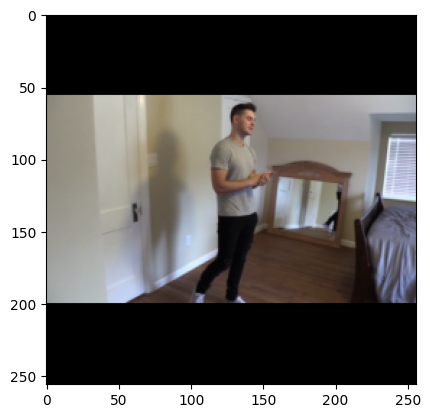

In [9]:
video, label, ID = experimental_dataset[10]
img = video[0]

display_image(img)
print(label)
print(video.shape)

Et comment faire un resize

torch.Size([3, 256, 256])


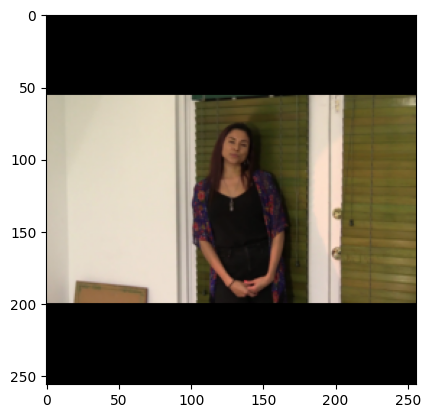

In [10]:
video, label, ID = experimental_dataset[0]
img=video[0]

img=smart_resize(img, 256)
print(img.shape)
display_image(img)

## Modèle

In [11]:
class DeepfakeDetector(nn.Module):
    def __init__(self, nb_frames=10):
        super().__init__()
        self.dense = nn.Linear(nb_frames*3*256*256,1)
        self.flat = nn.Flatten()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.flat(x)
        y = self.dense(y)
        y = self.sigmoid(y)
        return y


model = DeepfakeDetector(nb_frames=nb_frames)
print(video.shape)
video, label, ID = experimental_dataset[0]
video = video.unsqueeze(0) # add a batch dimension
summary(model, input_size=video.shape)

torch.Size([10, 3, 256, 256])


Layer (type:depth-idx)                   Output Shape              Param #
DeepfakeDetector                         [1, 1]                    --
├─Flatten: 1-1                           [1, 1966080]              --
├─Linear: 1-2                            [1, 1]                    1,966,081
├─Sigmoid: 1-3                           [1, 1]                    --
Total params: 1,966,081
Trainable params: 1,966,081
Non-trainable params: 0
Total mult-adds (M): 1.97
Input size (MB): 7.86
Forward/backward pass size (MB): 0.00
Params size (MB): 7.86
Estimated Total Size (MB): 15.73

# CNN INCHALLAH CA MARCHE 2D :(

In [41]:
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedCNN4(nn.Module):
    def __init__(self):
        in_channels = 3
        out_channels = 32
        k_size = 3
        stride_ = 1
        padding_ = 1
        pool_k_size = 2
        pool_stride = 2
        pool_padding = 0
        dropout_rate = 0.5

        

        super(EnhancedCNN4, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size= k_size, stride=stride_, padding=padding_)
        self.bn1 = nn.BatchNorm2d(out_channels)


        in_channels = out_channels
        out_channels = out_channels*2

        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size= k_size, stride= stride_, padding=padding_)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.pool1 = nn.MaxPool2d(kernel_size=pool_k_size, stride=pool_stride)

        in_channels = out_channels
        out_channels = out_channels*2

        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=k_size, stride=stride_, padding=padding_)
        self.bn3 = nn.BatchNorm2d(out_channels)

        in_channels = out_channels
        out_channels = out_channels*2

        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=k_size, stride=stride_, padding=padding_)
        self.bn4 = nn.BatchNorm2d(out_channels)

        self.pool2 = nn.MaxPool2d(kernel_size=pool_k_size, stride=pool_stride)
        



        # Calculate the size of the output from the last pooling layer
        def calc_output_dim(input_dim, kernel_size, stride, padding):
            return (input_dim - kernel_size + 2 * padding) // stride + 1
        
        #Initial dimension of the data is 64
        dim = 256
        # After conv1
        dim = calc_output_dim(dim, k_size, stride_, padding_)      
        # After conv2
        dim = calc_output_dim(dim, k_size, stride_, padding_)
        # After pool1
        dim = calc_output_dim(dim, pool_k_size, pool_stride, pool_padding)   
        # After conv3
        dim = calc_output_dim(dim, k_size, stride_, padding_)
        # After conv4
        dim = calc_output_dim(dim, k_size, stride_, padding_)

        # After pool2
        dim = calc_output_dim(dim, pool_k_size, pool_stride, pool_padding)          

        self.dropout = nn.Dropout(dropout_rate)
    
        self.fc = nn.Linear(in_features= out_channels*dim*dim, out_features=1024)
        
        #out_features is the number of classes we want to predict, here Cat and Dog so 2 classses
        self.fc2 = nn.Linear(in_features=1024 , out_features=2)
        

    def forward(self, x):
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(F.relu(self.bn4(self.conv4(x))))

        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc(x))
        x = (self.fc2(x))
        return x



# CNN 3D ?

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedCNN4_3D(nn.Module):
    def __init__(self):
        super(EnhancedCNN4_3D, self).__init__()
        in_channels = 3
        out_channels = 32
        k_size = (3, 3, 3)  # Kernel size now includes time dimension
        stride_ = (1, 1, 1)  # Stride now includes time dimension
        padding_ = (1, 1, 1)  # Padding now includes time dimension
        pool_k_size = (1, 2, 2)  # Pooling in the time dimension remains 1
        pool_stride = (1, 2, 2)  # Pooling stride in the time dimension
        pool_padding = (0, 0, 0)  # Pool padding
        dropout_rate = 0.5

        # Convolutional and BatchNorm layers now use 3D
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=k_size, stride=stride_, padding=padding_)
        self.bn1 = nn.BatchNorm3d(out_channels)

        in_channels = out_channels
        out_channels *= 2  # Doubling the output channels with each layer

        self.conv2 = nn.Conv3d(in_channels, out_channels, kernel_size=k_size, stride=stride_, padding=padding_)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.pool1 = nn.MaxPool3d(kernel_size=pool_k_size, stride=pool_stride, padding=pool_padding)

        in_channels = out_channels
        out_channels *= 2

        self.conv3 = nn.Conv3d(in_channels, out_channels, kernel_size=k_size, stride=stride_, padding=padding_)
        self.bn3 = nn.BatchNorm3d(out_channels)

        in_channels = out_channels
        out_channels *= 2

        self.conv4 = nn.Conv3d(in_channels, out_channels, kernel_size=k_size, stride=stride_, padding=padding_)
        self.bn4 = nn.BatchNorm3d(out_channels)
        self.pool2 = nn.MaxPool3d(kernel_size=pool_k_size, stride=pool_stride)

        # Assuming input depth is 10 frames and each frame is 256x256 pixels
        # This would need to be adjusted based on actual input size
        input_frames = 10
        dim = 256  # Initial dimension of the data in height and width
        for _ in range(2):  # Two pooling layers
            input_frames = (input_frames - pool_k_size[0] + 2 * pool_padding[0]) // pool_stride[0] + 1
            dim = (dim - pool_k_size[1] + 2 * pool_padding[1]) // pool_stride[1] + 1
            dim = (dim - pool_k_size[2] + 2 * pool_padding[2]) // pool_stride[2] + 1

        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(10485760, 1024)  # Adjusting for 3D volume
        self.fc2 = nn.Linear(1024, 2)  # Number of classes

    def forward(self, x):
        # x = F.relu(self.bn1(self.conv1(x)))
        # x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        # x = F.relu(self.bn3(self.conv3(x)))
        # x = self.pool2(F.relu(self.bn4(self.conv4(x))))
        
        # x = torch.flatten(x, 1)
        # x = self.dropout(x)
        # x = F.relu(self.fc(x))
        # x = self.fc2(x)
        # return x

        x = F.relu(self.bn1(self.conv1(x)))
        print("After conv1:", x.shape)  # Debug output
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        print("After pool1:", x.shape)  # Debug output
        x = F.relu(self.bn3(self.conv3(x)))
        print("After conv3:", x.shape)  # Debug output
        x = self.pool2(F.relu(self.bn4(self.conv4(x))))
        print("After pool2:", x.shape)  # Debug output
        
        x = torch.flatten(x, 1)
        print("Before fc:", x.shape)  # Debug output
        
        x = self.dropout(x)
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return x



## Logging

In [13]:
wandb.login(key="b15da3ba051c5858226f1d6b28aee6534682d044")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: othmane-menkor (otho). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/othmane/.netrc


True

In [14]:
run = wandb.init(
    project="authomathon Deep Fake Detection Otho Local",
)

## Entrainement

In [15]:
torch.cuda.device_count()

0

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

loss_fn = nn.MSELoss()
model = EnhancedCNN4_3D().to(device)
#model = DeepfakeDetector().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#epochs = 5
epochs = 5
loader = DataLoader(experimental_dataset, batch_size=2, shuffle=True)

for epoch in range(epochs):
    for sample in tqdm(loader, desc="Epoch {}".format(epoch), ncols=0):
        optimizer.zero_grad()
        X, label, ID = sample
        X = X.permute(0, 2, 1, 3, 4).to(device)  # Adjusting dimension order and moving to device
        X = X.to(device)
        label = label.to(device)
        #X = X.cuda()
        #label = label.cuda()
        label_pred = model(X)
        label=torch.unsqueeze(label,dim=1)
        loss = loss_fn(label, label_pred)
        loss.backward()
        optimizer.step()
        run.log({"loss": loss.item(), "epoch": epoch})

cpu


: 

: 

## Test

In [37]:
loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
model = model.to(device)
ids = []
labels = []
print("Testing...")
for sample in tqdm(loader):
    X, ID = sample
    #ID = ID[0]
    X = X.to(device)
    label_pred = model(X)
    ids.extend(list(ID))
    pred = (label_pred > 0.5).long()
    pred = pred.cpu().detach().numpy().tolist()
    labels.extend(pred)


Testing...


100%|██████████| 557/557 [06:32<00:00,  1.42it/s]


### Saving

In [38]:
print("Saving...")
tests = ["id,label\n"] + [f"{ID},{label_pred[0]}\n" for ID, label_pred in zip(ids, labels)]
with open("submission.csv", "w") as file:
    file.writelines(tests)


Saving...
